In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [40]:

# Load dataset
df = pd.read_excel('../data/Dataset_2020-2024.xlsx')

In [41]:
# --- Pembersihan Data Awal ---
# Mengganti nilai '8888', '9999', dan '-' dengan NaN (Not a Number)
df = df.replace(['8888', '9999', '-', 8888, 9999], np.nan)
df = df.infer_objects()


# Mendefinisikan kolom-kolom yang seharusnya numerik
numeric_columns = ['TN', 'TX', 'TAVG', 'RH_AVG', 'RR', 'SS']
# Mengonversi kolom-kolom numerik yang mungkin bertipe object menjadi float
# 'errors="coerce"' mengubah nilai yang tidak bisa dikonversi menjadi NaN
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\n--- Informasi Setelah Penggantian NaN & Konversi Tipe ---")
df[numeric_columns].info()
print("\n--- 10 Baris Pertama Setelah Penggantian NaN & Konversi Tipe ---")
print(df.head(10))


--- Informasi Setelah Penggantian NaN & Konversi Tipe ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814 entries, 0 to 1813
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TN      1633 non-null   float64
 1   TX      1770 non-null   float64
 2   TAVG    1794 non-null   float64
 3   RH_AVG  1796 non-null   float64
 4   RR      1327 non-null   float64
 5   SS      1760 non-null   float64
dtypes: float64(6)
memory usage: 85.2 KB

--- 10 Baris Pertama Setelah Penggantian NaN & Konversi Tipe ---
      TANGGAL    TN    TX  TAVG  RH_AVG    RR   SS  FF_X  DDD_X  FF_AVG  \
0  01-01-2020  25.0  31.2  25.4    91.0  19.9  3.2    10    220       2   
1  02-01-2020  24.2  32.0  27.5    85.0  14.8  1.0     4    240       1   
2  03-01-2020  25.1  32.0  27.5    86.0   2.1  3.5     8    250       2   
3  04-01-2020  24.9  31.8  27.5    88.0   2.5  4.0     7    230       2   
4  05-01-2020  25.2  29.7  26.3    91.0   6.5  4.5     4 

C:\Users\HP\AppData\Local\Temp\ipykernel_5936\1533749833.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(['8888', '9999', '-', 8888, 9999], np.nan)


In [42]:
# --- Pengurutan Data Berdasarkan Waktu ---
# Mengubah 'Tanggal' menjadi 'TANGGAL' sesuai dengan output df.info()
if 'TANGGAL' in df.columns:
    # Menentukan format tanggal secara eksplisit sebagai DD-MM-YYYY
    df['TANGGAL'] = pd.to_datetime(df['TANGGAL'], format='%d-%m-%Y')
    df = df.sort_values(by='TANGGAL').reset_index(drop=True)
    print("\nData berhasil diurutkan berdasarkan kolom 'TANGGAL'.")
else:
    print("\nKolom 'TANGGAL' tidak ditemukan. Mengasumsikan data sudah terurut waktu.")

print("\n--- Informasi Setelah Pengurutan Berdasarkan Waktu ---")
print(df.head())


Data berhasil diurutkan berdasarkan kolom 'TANGGAL'.

--- Informasi Setelah Pengurutan Berdasarkan Waktu ---
     TANGGAL    TN    TX  TAVG  RH_AVG    RR   SS  FF_X  DDD_X  FF_AVG DDD_CAR
0 2020-01-01  25.0  31.2  25.4    91.0  19.9  3.2    10    220       2      NW
1 2020-01-02  24.2  32.0  27.5    85.0  14.8  1.0     4    240       1      C 
2 2020-01-03  25.1  32.0  27.5    86.0   2.1  3.5     8    250       2      C 
3 2020-01-04  24.9  31.8  27.5    88.0   2.5  4.0     7    230       2      C 
4 2020-01-05  25.2  29.7  26.3    91.0   6.5  4.5     4    240       2      C 


In [43]:
# --- Imputasi Missing Values untuk Semua Kolom Numerik ---
columns_to_impute = df.select_dtypes(include=np.number).columns.tolist()
# Menghapus 'TANGGAL' dari daftar jika terdeteksi sebagai numerik setelah konversi
if 'TANGGAL' in columns_to_impute:
    columns_to_impute.remove('TANGGAL')

imputer = SimpleImputer(strategy='median')
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

print("\n--- Jumlah NaN Setelah Imputasi Awal Semua Kolom Numerik ---")
print(df.isna().sum())


--- Jumlah NaN Setelah Imputasi Awal Semua Kolom Numerik ---
TANGGAL    0
TN         0
TX         0
TAVG       0
RH_AVG     0
RR         0
SS         0
FF_X       0
DDD_X      0
FF_AVG     0
DDD_CAR    0
dtype: int64


In [44]:

# --- Pembuatan Fitur Lag ---
# Fitur lag : nilai dari variabel yang sama dari periode waktu sebelumnya.
# shift(1) : mengambil nilai dari satu periode waktu sebelumnya (misalnya, hari kemarin)
df['RR_lag1'] = df['RR'].shift(1)
df['TAVG_lag1'] = df['TAVG'].shift(1)
df['RH_AVG_lag1'] = df['RH_AVG'].shift(1)
df['SS_lag1'] = df['SS'].shift(1)
df['TX_lag1'] = df['TX'].shift(1)
df['TN_lag1'] = df['TN'].shift(1)

df['RR_rolling_mean_3d_lag1'] = df['RR'].rolling(window=3, min_periods=1).mean().shift(1)

print("\n--- 10 Baris Pertama Setelah Pembuatan Fitur Lag ---")
print(df.head(10))
print("\n--- Jumlah NaN Setelah Pembuatan Fitur Lag ---")
print(df.isna().sum())



--- 10 Baris Pertama Setelah Pembuatan Fitur Lag ---
     TANGGAL    TN    TX  TAVG  RH_AVG    RR    SS  FF_X  DDD_X  FF_AVG  \
0 2020-01-01  25.0  31.2  25.4    91.0  19.9  3.20  10.0  220.0     2.0   
1 2020-01-02  24.2  32.0  27.5    85.0  14.8  1.00   4.0  240.0     1.0   
2 2020-01-03  25.1  32.0  27.5    86.0   2.1  3.50   8.0  250.0     2.0   
3 2020-01-04  24.9  31.8  27.5    88.0   2.5  4.00   7.0  230.0     2.0   
4 2020-01-05  25.2  29.7  26.3    91.0   6.5  4.50   4.0  240.0     2.0   
5 2020-01-06  24.2  32.2  27.6    84.0  12.5  0.50   4.0  240.0     2.0   
6 2020-01-07  25.0  29.6  26.8    89.0  23.8  6.30   4.0  290.0     1.0   
7 2020-01-08  25.0  29.4  27.3    85.0  13.7  6.85   4.0  180.0     1.0   
8 2020-01-10  24.8  31.4  26.7    85.0  24.0  2.50   4.0  210.0     1.0   
9 2020-01-11  24.0  31.5  27.3    84.0  17.1  1.40   5.0  240.0     2.0   

  DDD_CAR  RR_lag1  TAVG_lag1  RH_AVG_lag1  SS_lag1  TX_lag1  TN_lag1  \
0      NW      NaN        NaN          NaN     

In [45]:
# --- Penanganan NaN Setelah Fitur Lag ---
df_preprocessed_full = df.copy()
df.dropna(inplace=True)

print("\n--- Jumlah NaN Setelah Menghapus Baris dengan NaN Fitur Lag ---")
print(df.isna().sum())
print("\n--- Informasi Data Setelah Menghapus Baris dengan NaN Fitur Lag ---")
df.info()
print("\n--- 10 Baris Pertama Data Setelah Pembersihan Total & Fitur Lag ---")
print(df.head(10))


--- Jumlah NaN Setelah Menghapus Baris dengan NaN Fitur Lag ---
TANGGAL                    0
TN                         0
TX                         0
TAVG                       0
RH_AVG                     0
RR                         0
SS                         0
FF_X                       0
DDD_X                      0
FF_AVG                     0
DDD_CAR                    0
RR_lag1                    0
TAVG_lag1                  0
RH_AVG_lag1                0
SS_lag1                    0
TX_lag1                    0
TN_lag1                    0
RR_rolling_mean_3d_lag1    0
dtype: int64

--- Informasi Data Setelah Menghapus Baris dengan NaN Fitur Lag ---
<class 'pandas.core.frame.DataFrame'>
Index: 1813 entries, 1 to 1813
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   TANGGAL                  1813 non-null   datetime64[ns]
 1   TN                       1813 non-null   

In [46]:
# --- 7. Feature Engineering: Kategorisasi Curah Hujan ---
# Mengubah nilai numerik curah hujan (RR) menjadi kategori

def rr_categorization(rr):
    if rr == 0:
        return 'No Rain'
    elif 0 < rr <= 20:
        return 'Hujan Ringan'
    elif 20 < rr <= 50:
        return 'Hujan Sedang'
    elif 50 < rr <= 100:
        return 'Hujan Lebat'
    else:
        return 'Hujan Sangat Lebat'

df['RR_KAT'] = df['RR'].apply(rr_categorization)


print("\n--- Distribusi Kategori Curah Hujan (RR_KAT) ---")
print(df['RR_KAT'].value_counts())


--- Distribusi Kategori Curah Hujan (RR_KAT) ---
RR_KAT
Hujan Ringan          1245
No Rain                300
Hujan Sedang           177
Hujan Lebat             72
Hujan Sangat Lebat      19
Name: count, dtype: int64


In [47]:
# --- 8. Label Encoding untuk Target ---
# Mengubah kategori teks menjadi representasi numerik
le = LabelEncoder()
df['RR_KAT_ENC'] = le.fit_transform(df['RR_KAT'])

# Membuat mapping dari label asli ke angka untuk interpretasi hasil
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("\n--- Label Encoding Mapping ---")
for original, encoded in label_mapping.items():
    print(f"{original} → {encoded}")


--- Label Encoding Mapping ---
Hujan Lebat → 0
Hujan Ringan → 1
Hujan Sangat Lebat → 2
Hujan Sedang → 3
No Rain → 4


In [48]:
# --- 9. Pemisahan Fitur (X) dan Target (y) ---
# Mendefinisikan semua kolom yang akan digunakan sebagai fitur (input model)
feature_columns = [
    'TN', 'TX', 'TAVG', 'RH_AVG', 'SS',
    'RR_lag1', 'TAVG_lag1', 'RH_AVG_lag1', 'SS_lag1', 'TX_lag1', 'TN_lag1',
    'RR_rolling_mean_3d_lag1'
]

X = df[feature_columns] 
y = df['RR_KAT_ENC']    

print("\n--- Head X (Fitur) ---")
print(X.head())
print("\n--- Head y (Target) ---")
print(y.head())


--- Head X (Fitur) ---
     TN    TX  TAVG  RH_AVG   SS  RR_lag1  TAVG_lag1  RH_AVG_lag1  SS_lag1  \
1  24.2  32.0  27.5    85.0  1.0     19.9       25.4         91.0      3.2   
2  25.1  32.0  27.5    86.0  3.5     14.8       27.5         85.0      1.0   
3  24.9  31.8  27.5    88.0  4.0      2.1       27.5         86.0      3.5   
4  25.2  29.7  26.3    91.0  4.5      2.5       27.5         88.0      4.0   
5  24.2  32.2  27.6    84.0  0.5      6.5       26.3         91.0      4.5   

   TX_lag1  TN_lag1  RR_rolling_mean_3d_lag1  
1     31.2     25.0                19.900000  
2     32.0     24.2                17.350000  
3     32.0     25.1                12.266667  
4     31.8     24.9                 6.466667  
5     29.7     25.2                 3.700000  

--- Head y (Target) ---
1    1
2    1
3    1
4    1
5    1
Name: RR_KAT_ENC, dtype: int64


In [49]:
# --- 10. Standardisasi Fitur ---
# Menskalakan fitur sehingga memiliki rata-rata 0 dan standar deviasi 1.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Mengonversi kembali ke DataFrame untuk memudahkan analisis lebih lanjut
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_columns, index=X.index)

print("\n--- Head X Setelah Standardisasi ---")
print(X_scaled_df.head())



--- Head X Setelah Standardisasi ---
         TN        TX      TAVG    RH_AVG        SS   RR_lag1  TAVG_lag1  \
1 -0.808190  0.802128  0.076228  0.486611 -1.759318  0.465337  -2.021868   
2  0.177477  0.802128  0.076228  0.771843 -0.906262  0.222757   0.077300   
3 -0.041560  0.656199  0.076228  1.342309 -0.735651 -0.381316   0.077300   
4  0.286995 -0.876058 -1.124650  2.198007 -0.565040 -0.362290   0.077300   
5 -0.808190  0.948057  0.176301  0.201378 -1.929929 -0.172031  -1.122225   

   RH_AVG_lag1   SS_lag1   TX_lag1   TN_lag1  RR_rolling_mean_3d_lag1  
1     2.193892 -1.007905  0.218769  0.067660                 0.734168  
2     0.484353 -1.758391  0.802582 -0.808543                 0.542796  
3     0.769277 -0.905566  0.802582  0.177186                 0.161302  
4     1.339123 -0.735001  0.656629 -0.041865                -0.273976  
5     2.193892 -0.564436 -0.875880  0.286711                -0.481609  



--- Distribusi Target Sebelum SMOTE ---
Counter({1: 1245, 4: 300, 3: 177, 0: 72, 2: 19})


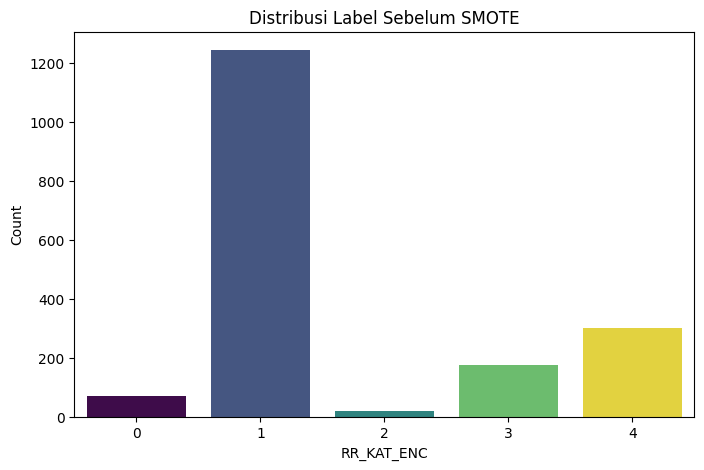


--- Distribusi Target Setelah SMOTE ---
Counter({1: 1245, 3: 1245, 4: 1245, 0: 1245, 2: 1245})


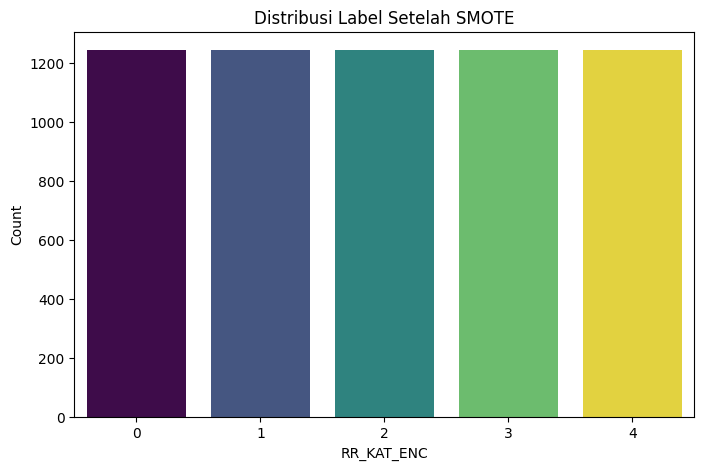

In [50]:
# --- Penanganan Imbalance Data (SMOTE) ---

print("\n--- Distribusi Target Sebelum SMOTE ---")
print(Counter(y))
# Distribusi Target Sebelum SMOTE
plt.figure(figsize=(8, 5))
sns.countplot(x=y, hue=y, palette='viridis', legend=False)
plt.title("Distribusi Label Sebelum SMOTE")
plt.xlabel("RR_KAT_ENC")
plt.ylabel("Count")
plt.show()

smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_scaled, y)

print("\n--- Distribusi Target Setelah SMOTE ---")
print(Counter(y_bal))

plt.figure(figsize=(8, 5))
sns.countplot(x=y_bal, hue=y_bal, palette='viridis', legend=False)
plt.title("Distribusi Label Setelah SMOTE")
plt.xlabel("RR_KAT_ENC")
plt.ylabel("Count")
plt.show()



In [51]:

# ---Split Data---
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

print("\n--- Distribusi Data Setelah Split ---")
print("Distribusi Train:")
print(Counter(y_train))
print("\nDistribusi Test:")
print(Counter(y_test))

print("\nPreprocessing Lengkap! X_train, X_test, y_train, y_test siap untuk pelatihan model.")


--- Distribusi Data Setelah Split ---
Distribusi Train:
Counter({4: 996, 3: 996, 2: 996, 1: 996, 0: 996})

Distribusi Test:
Counter({4: 249, 3: 249, 1: 249, 2: 249, 0: 249})

Preprocessing Lengkap! X_train, X_test, y_train, y_test siap untuk pelatihan model.


In [52]:
# --- Pelatihan Model ---
print("\n--- Memulai Pelatihan Model ---")

# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
print("\n=== Naive Bayes ===")
print("Akurasi:", accuracy_score(y_test, nb_pred))
print(classification_report(y_test, nb_pred, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, nb_pred))

# KNN
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
print("\n=== K-Nearest Neighbors ===")
print("Akurasi:", accuracy_score(y_test, knn_pred))
print(classification_report(y_test, knn_pred, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, knn_pred))

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print("\n=== Random Forest ===")
print("Akurasi:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_pred))


--- Memulai Pelatihan Model ---

=== Naive Bayes ===
Akurasi: 0.4530120481927711
                    precision    recall  f1-score   support

       Hujan Lebat       0.33      0.25      0.29       249
      Hujan Ringan       0.48      0.12      0.19       249
Hujan Sangat Lebat       0.54      0.60      0.57       249
      Hujan Sedang       0.41      0.50      0.45       249
           No Rain       0.48      0.79      0.59       249

          accuracy                           0.45      1245
         macro avg       0.45      0.45      0.42      1245
      weighted avg       0.45      0.45      0.42      1245

Confusion Matrix:
 [[ 63   4  63  90  29]
 [ 15  30  24  52 128]
 [ 63   0 150  15  21]
 [ 47  12  27 124  39]
 [  5  17  12  18 197]]

=== K-Nearest Neighbors ===
Akurasi: 0.8289156626506025
                    precision    recall  f1-score   support

       Hujan Lebat       0.89      1.00      0.94       249
      Hujan Ringan       0.80      0.28      0.42       249
Hu

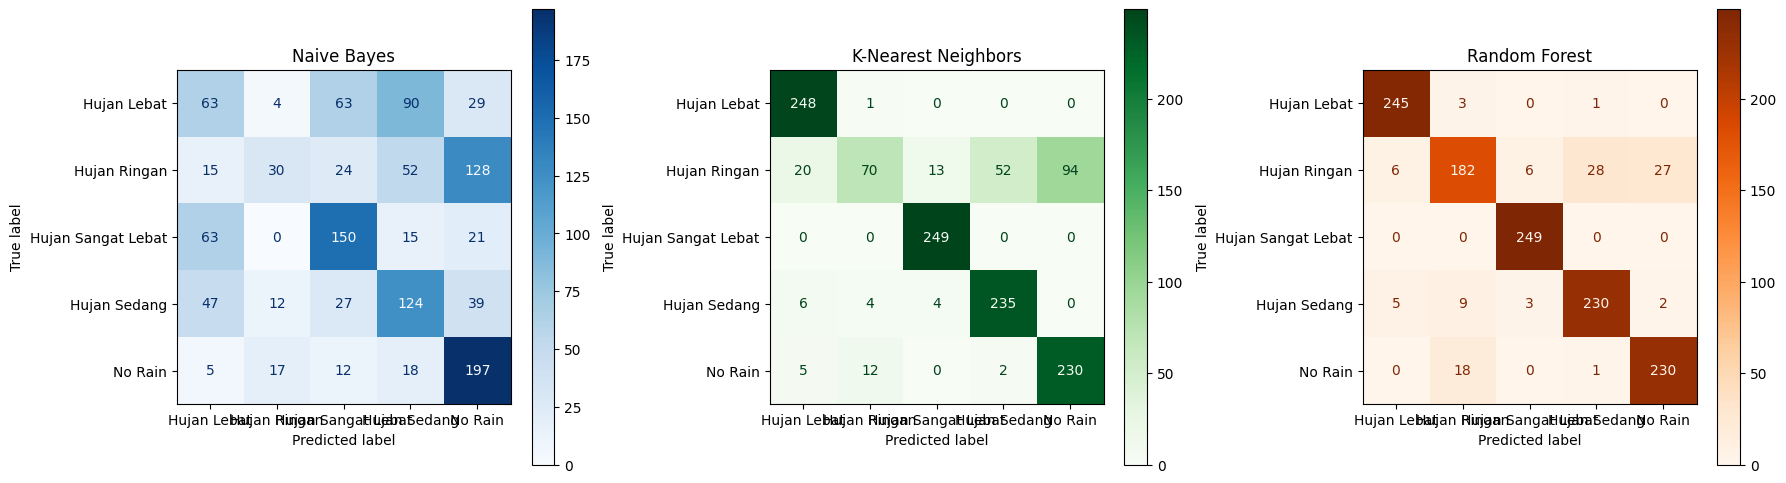

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay

# Visualisasi Confusion Matrix
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ConfusionMatrixDisplay.from_estimator(nb_model, X_test, y_test, display_labels=le.classes_, cmap='Blues', ax=axes[0])
axes[0].set_title("Naive Bayes")

ConfusionMatrixDisplay.from_estimator(knn_model, X_test, y_test, display_labels=le.classes_, cmap='Greens', ax=axes[1])
axes[1].set_title("K-Nearest Neighbors")

ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, display_labels=le.classes_, cmap='Oranges', ax=axes[2])
axes[2].set_title("Random Forest")

plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_5936\2314778213.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=akurasi_values, palette='viridis')


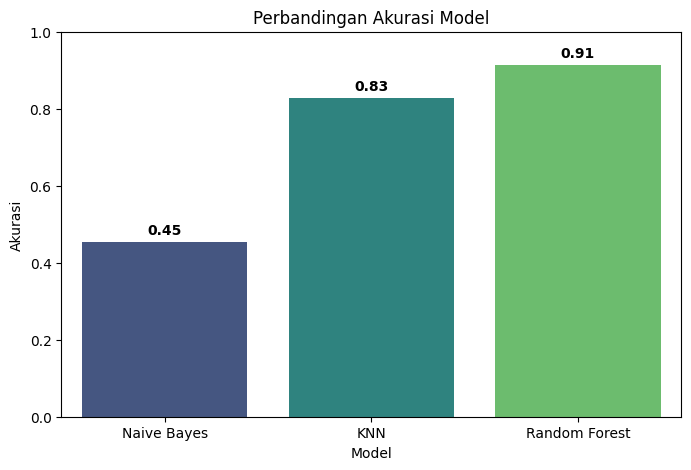

In [54]:
# Akurasi masing-masing model
akurasi_nb = accuracy_score(y_test, nb_pred)
akurasi_knn = accuracy_score(y_test, knn_pred)
akurasi_rf = accuracy_score(y_test, rf_pred)

# Bar Chart Akurasi
model_names = ['Naive Bayes', 'KNN', 'Random Forest']
akurasi_values = [akurasi_nb, akurasi_knn, akurasi_rf]

plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=akurasi_values, palette='viridis')
plt.ylim(0, 1)
plt.title('Perbandingan Akurasi Model')
plt.ylabel('Akurasi')
plt.xlabel('Model')
for i, v in enumerate(akurasi_values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()


In [55]:

# --- 14. Prediksi Beberapa Hari ke Depan ---
print("\n--- Memulai Prediksi untuk Beberapa Hari ke Depan (Semua Model) ---")

# Ambil data aktual terakhir dari DataFrame yang sudah di-preprocess lengkap
last_actual_data = df_preprocessed_full.iloc[-1]
# Menggunakan 'TANGGAL' sesuai dengan nama kolom yang benar
last_actual_date = last_actual_data['TANGGAL']

# Untuk jumlah hari yang ingin diprediksi
n_future_days = 5
future_dates = [last_actual_date + pd.Timedelta(days=i) for i in range(1, n_future_days + 1)]

# List of models to iterate through for prediction
models_to_predict = {
    "Naive Bayes": nb_model,
    "K-Nearest Neighbors": knn_model,
    "Random Forest": rf_model
}

# Loop untuk memprediksi setiap hari ke depan
for i, current_future_date in enumerate(future_dates):
    print(f"\n--- Prediksi untuk Tanggal: {current_future_date.strftime('%Y-%m-%d')} ---")

    #mengasumsikan nilai fitur langsung (TN, TX, dll.)
    # untuk hari-hari mendatang. 
    # menggunakan rata-rata dari 7 hari terakhir data aktual
    avg_last_7_days = df_preprocessed_full[numeric_columns].iloc[-7:].mean()

    # Buat baris data untuk hari yang akan diprediksi
    current_future_features = {
        'TN': avg_last_7_days['TN'],
        'TX': avg_last_7_days['TX'],
        'TAVG': avg_last_7_days['TAVG'],
        'RH_AVG': avg_last_7_days['RH_AVG'],
        'RR': avg_last_7_days['RR'], # RR ini hanya untuk perhitungan lag (bukan target jadi gapapa dimasukin)
        'SS': avg_last_7_days['SS']
    }

    # Hitung fitur lag untuk hari ini berdasarkan data aktual terakhir
    # atau data yang sudah diprediksi sebelumnya 
    if i == 0: # Hari pertama prediksi
        current_future_features['RR_lag1'] = last_actual_data['RR']
        current_future_features['TAVG_lag1'] = last_actual_data['TAVG']
        current_future_features['RH_AVG_lag1'] = last_actual_data['RH_AVG']
        current_future_features['SS_lag1'] = last_actual_data['SS']
        current_future_features['TX_lag1'] = last_actual_data['TX']
        current_future_features['TN_lag1'] = last_actual_data['TN']

        # Untuk RR_rolling_mean_3d_lag1, menggunakan 3 data terakhir
        # Ambil 2 data sebelum last_actual_data + last_actual_data
        recent_rr_for_rolling = df_preprocessed_full['RR'].iloc[-2:].tolist() + [last_actual_data['RR']]
        current_future_features['RR_rolling_mean_3d_lag1'] = np.mean(recent_rr_for_rolling)

    else: # Hari-hari prediksi selanjutnya, lag diambil dari prediksi hari sebelumnya
        current_future_features['RR_lag1'] = avg_last_7_days['RR']
        current_future_features['TAVG_lag1'] = avg_last_7_days['TAVG']
        current_future_features['RH_AVG_lag1'] = avg_last_7_days['RH_AVG']
        current_future_features['SS_lag1'] = avg_last_7_days['SS']
        current_future_features['TX_lag1'] = avg_last_7_days['TX']
        current_future_features['TN_lag1'] = avg_last_7_days['TN']
        current_future_features['RR_rolling_mean_3d_lag1'] = avg_last_7_days['RR'] # Proxy

    # Buat DataFrame dari dictionary buat ngisi keys secara otomatis
    current_future_row = pd.DataFrame([current_future_features])
    # memilih kolom-kolom sesuai dengan feature_columns utk mastiin urutan yang benar
    current_future_row_for_scaling = current_future_row[feature_columns]

    # Skalakan data prediksi menggunakan scaler yang sama pada data training
    scaled_future_row = scaler.transform(current_future_row_for_scaling)

    # Lakukan prediksi dengan setiap model
    for model_name, model in models_to_predict.items():
        predicted_category_encoded = model.predict(scaled_future_row)[0]
        predicted_category_name = le.inverse_transform([predicted_category_encoded])[0]
        print(f"  Prediksi oleh {model_name}: {predicted_category_name}")

    print(f"  Fitur Input (Asumsi): {{k: round(v, 2) for k, v in current_future_features.items()}}")
    print("-" * 50)

print("\nPrediksi selesai.")


--- Memulai Prediksi untuk Beberapa Hari ke Depan (Semua Model) ---

--- Prediksi untuk Tanggal: 2025-01-01 ---
  Prediksi oleh Naive Bayes: Hujan Ringan
  Prediksi oleh K-Nearest Neighbors: No Rain
  Prediksi oleh Random Forest: Hujan Ringan
  Fitur Input (Asumsi): {k: round(v, 2) for k, v in current_future_features.items()}
--------------------------------------------------

--- Prediksi untuk Tanggal: 2025-01-02 ---
  Prediksi oleh Naive Bayes: Hujan Sedang
  Prediksi oleh K-Nearest Neighbors: No Rain
  Prediksi oleh Random Forest: No Rain
  Fitur Input (Asumsi): {k: round(v, 2) for k, v in current_future_features.items()}
--------------------------------------------------

--- Prediksi untuk Tanggal: 2025-01-03 ---
  Prediksi oleh Naive Bayes: Hujan Sedang
  Prediksi oleh K-Nearest Neighbors: No Rain
  Prediksi oleh Random Forest: No Rain
  Fitur Input (Asumsi): {k: round(v, 2) for k, v in current_future_features.items()}
--------------------------------------------------

--- Pre

In [56]:
import joblib

joblib.dump(nb_model, '../model/naive_bayes_model.pkl')
joblib.dump(knn_model, '../model/knn_model.pkl')
joblib.dump(rf_model, '../model/random_forest_model.pkl')
joblib.dump(scaler, '../model/scaler.pkl')
joblib.dump(le, '../model/label_encoder.pkl')


['../model/label_encoder.pkl']

In [57]:
# Simpan X_test dan y_test ke dalam file CSV
X_test_df = pd.DataFrame(X_test, columns=feature_columns)
X_test_df.to_csv('../data/X_test_preprocessed.csv', index=False)

y_test_df = pd.DataFrame({'RR_KAT_ENC': y_test})
y_test_df.to_csv('../data/y_test_preprocessed.csv', index=False)

print("✅ Semua model dan data test berhasil disimpan!")

✅ Semua model dan data test berhasil disimpan!
